In [1]:
!python -m pip install numpy pandas prophet

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from prophet import Prophet
from datetime import timedelta

mpl.style.use("seaborn")

Importing plotly failed. Interactive plots will not work.


In [3]:
dataframe = pd.read_csv(
    "data/germany_vaccinations_timeseries_v2.tsv",
    sep="\t",
    parse_dates=["date"]
)
dataframe.head()

,date,dosen_kumulativ,dosen_differenz_zum_vortag,dosen_erst_differenz_zum_vortag,dosen_zweit_differenz_zum_vortag,dosen_biontech_kumulativ,dosen_moderna_kumulativ,dosen_astrazeneca_kumulativ,personen_erst_kumulativ,personen_voll_kumulativ,...,indikation_alter_erst,indikation_beruf_erst,indikation_medizinisch_erst,indikation_pflegeheim_erst,indikation_alter_voll,indikation_beruf_voll,indikation_medizinisch_voll,indikation_pflegeheim_voll,dosen_dim_kumulativ,dosen_kbv_kumulativ
0,2020-12-27,24504,24504,24493,11,24504,0,0,24493,11,...,10664,8590,1305,12536,41,67,0,68,24504,0
1,2020-12-28,42886,18382,18382,0,42886,0,0,42875,11,...,18580,15721,1991,21276,41,67,0,68,42886,0
2,2020-12-29,92059,49173,48584,589,92059,0,0,91459,600,...,34724,40420,3107,40099,265,314,0,409,92059,0
3,2020-12-30,154470,62411,62407,4,154470,0,0,153866,604,...,55243,73050,4901,62794,267,315,0,412,154470,0
4,2020-12-31,204534,50064,49924,140,204534,0,0,203790,744,...,72517,96367,6752,83476,314,352,0,489,204534,0


In [4]:
df_german_holidays = pd.read_csv(
    "data/german_holidays.csv",
    parse_dates=["Tag"],
    sep=";"
    )["Tag"]

In [5]:
df_kumulative = dataframe[["date", "dosen_kumulativ"]]

column_rename_schema = {
    'date':'ds',
    'dosen_kumulativ':'y',
}

df_kumulative.rename(columns = column_rename_schema, inplace = True)

df_kumulative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      120 non-null    datetime64[ns]
 1   y       120 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.0 KB
/home/codedrift/.local/share/virtualenvs/jupyter-Vg80K4El/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:xlabel='ds'>

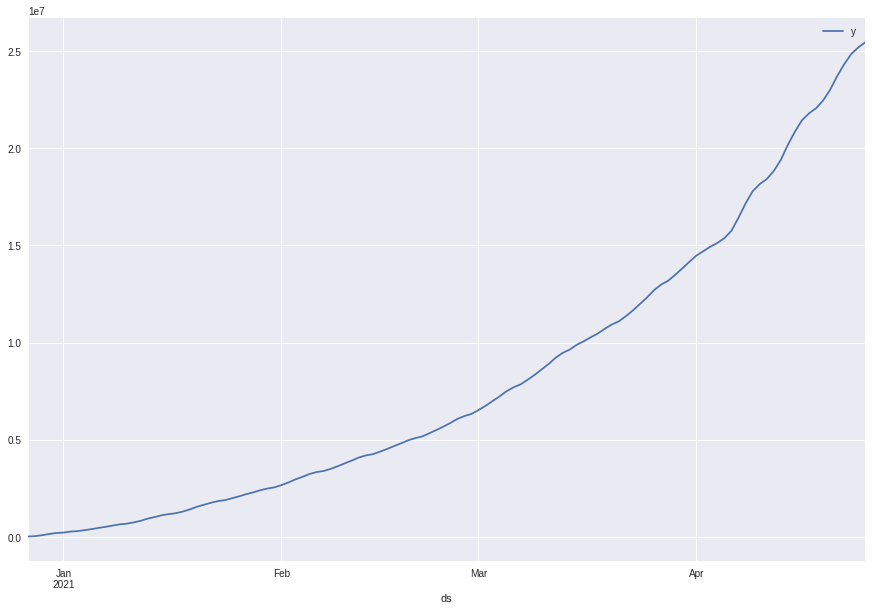

In [6]:
df_kumulative.plot(kind="line", x="ds", y="y", figsize=(15,10))

In [30]:
holidays = pd.DataFrame({
  'holiday': 'Deutscher Feiertag',
  'ds': df_german_holidays,
  'lower_window': 0,
  'upper_window': 1,
})

prophet = Prophet(weekly_seasonality=True, holidays=holidays)

prophet.add_country_holidays(country_name = 'DE')

prophet.fit(df_kumulative)

future = prophet.make_future_dataframe(periods=200)

forecast = prophet.predict(future)

fig_forecast = plt.figure(dpi=200)

fig_forecast.set_facecolor("white")

ax=fig_forecast.gca()
# disable scientific numbers
ax.ticklabel_format(useOffset=False, style='plain')

german_population = 83020000
german_population_herd = german_population * 0.7

first_date = df_kumulative["ds"].loc[0]
last_date = df_kumulative["ds"].loc[len(df_kumulative) - 1]

print(first_date, last_date, german_population)

# ax.plot(df_kumulative["ds"], german_population, '-g')
# ax.plot(first_date, german_population_herd, last_date, german_population_herd, marker = 'o')

prophet_plot_forecast_fig = prophet.plot(forecast, ax=ax);

prophet_plot_forecast_fig.savefig('output/forecast.png')

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2020-12-27 00:00:00 2021-04-25 00:00:00 83020000


ValueError: x and y must have same first dimension, but have shapes (120,) and (1,)

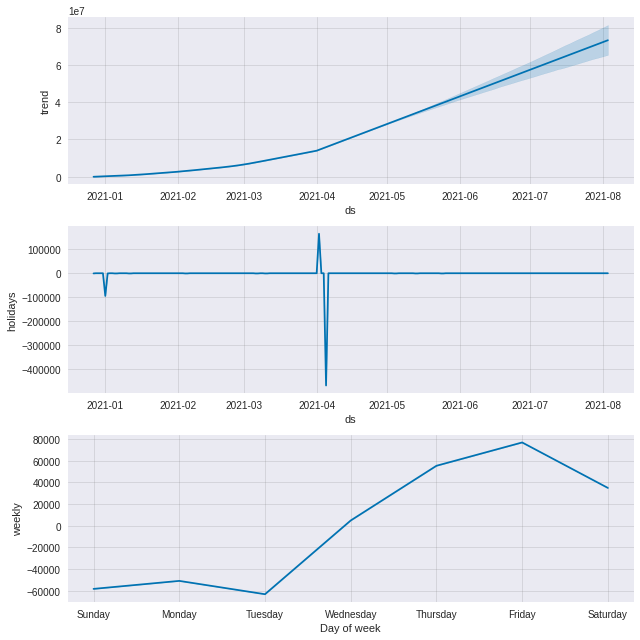

In [27]:
prophet.plot_components(forecast);